In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Define dataset paths
dataset_directory = '/Users/dipeshsharma/Downloads/archive-5'
train_directory = os.path.join(dataset_directory, 'train')
test_directory = os.path.join(dataset_directory, 'test')

In [3]:
# Count images in each training class
print("Train directory:")
for folder in os.listdir(train_directory):
    folder_path = os.path.join(train_directory, folder)
    if os.path.isdir(folder_path):  # Check if it's a directory
        print(f"{folder} contains {len(os.listdir(folder_path))} images")

Train directory:
large_cell_carcinoma contains 115 images
squamous_cell_carcinoma contains 155 images
adenocarcinoma contains 194 images
normal contains 148 images


In [4]:
# Count images in each testing class
print("\nTest directory:")
for folder in os.listdir(test_directory):
    folder_path = os.path.join(test_directory, folder)
    if os.path.isdir(folder_path):  # Check if it's a directory
        print(f"{folder} contains {len(os.listdir(folder_path))} images")


Test directory:
large_cell_carcinoma contains 51 images
squamous_cell_carcinoma contains 90 images
adenocarcinoma contains 120 images
normal contains 54 images


In [ ]:
class_order = ['adenocarcinoma', 'large_cell_carcinoma', 'normal', 'squamous_cell_carcinoma']

In [6]:
# Data Generators with specified class order
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=class_order  # Manually set the class order here
)

Found 491 images belonging to 4 classes.


In [8]:
validation_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    classes=class_order  # Ensure consistent class order in validation
)

Found 121 images belonging to 4 classes.


In [9]:
# Model Definition
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.4),
    layers.Dense(4, activation='softmax')  # 4 classes (normal + 3 cancers)
])

/Users/dipeshsharma/Desktop/Hoping Minds/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Model Compilation
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Model Training
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    classes=class_order  # Maintain consistent class order for test data
)

/Users/dipeshsharma/Desktop/Hoping Minds/myenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 324ms/step - accuracy: 0.3264 - loss: 1.3581 - val_accuracy: 0.4628 - val_loss: 1.2168
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.4635 - loss: 1.2291 - val_accuracy: 0.4628 - val_loss: 1.1439
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.4396 - loss: 1.1538 - val_accuracy: 0.5950 - val_loss: 1.0584
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 297ms/step - accuracy: 0.5397 - loss: 1.0756 - val_accuracy: 0.5041 - val_loss: 0.9441
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.6246 - loss: 0.8940 - val_accuracy: 0.7273 - val_loss: 0.8023
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.7273 - loss: 0.7802 - val_accuracy: 0.7190 - val_loss: 0.7239
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.7687 - loss: 0.6691 - val_accuracy: 0.7273 - val_loss: 0.6359
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - accuracy: 0.8077 - loss: 0.5679 - val_accuracy: 0.

In [11]:
# Model Evaluation
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.4792 - loss: 1.9230
Test Loss: 1.8838187456130981, Test Accuracy: 0.4952380955219269


In [12]:
# Confusion Matrix & Classification Report
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step


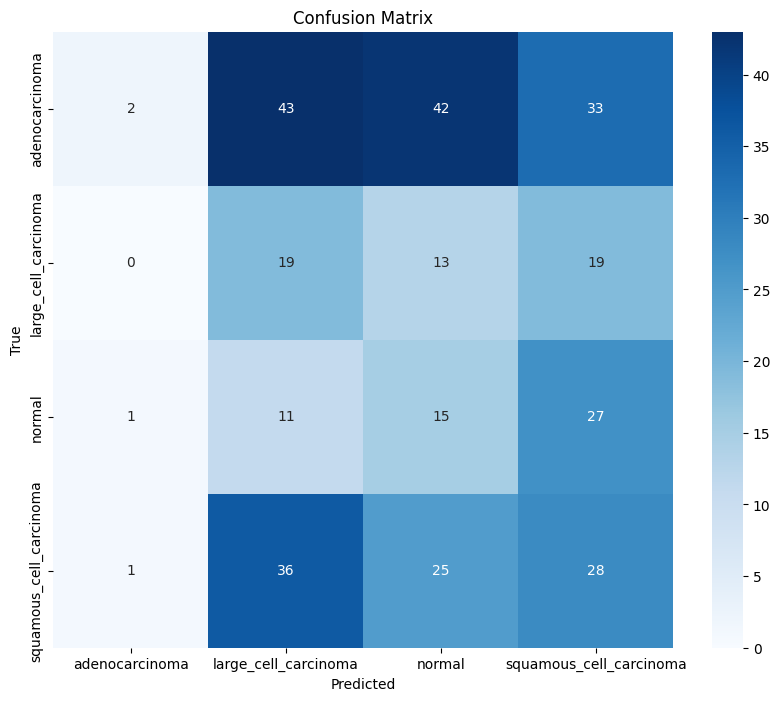

In [13]:
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
print(classification_report(true_labels, predicted_classes, target_names=test_generator.class_indices.keys()))

                         precision    recall  f1-score   support

         adenocarcinoma       0.50      0.02      0.03       120
   large_cell_carcinoma       0.17      0.37      0.24        51
                 normal       0.16      0.28      0.20        54
squamous_cell_carcinoma       0.26      0.31      0.28        90

               accuracy                           0.20       315
              macro avg       0.27      0.24      0.19       315
           weighted avg       0.32      0.20      0.17       315



In [15]:
# Save the Model
model.save('lung_cancer_detection_model.h5')